In [1]:
%matplotlib inline
#%matplotlib notebook

import matplotlib.pyplot as plt
import numpy as np
import scipy.constants as const
import time
import csv
from itertools import chain

from qutip import *

np.set_printoptions(threshold=np.inf)

In [12]:
'''
Define all of our relevant basis.
'''
i=np.complex(0,1)

'''
Rotation from Lab -> Atom: R_AL: {|+>,|->} -> {|H>,|V>}

R_AL.|+>_A = |+>_L --> R_AL.(1 0)^tr = (1  i)^tr / sqrt(2)
R_AL.|->_A = |->_L --> R_AL.(0 1)^tr = (1 -i)^tr / sqrt(2)
'''
R_AL = np.sqrt(1/2) * np.matrix([[1, i],
                                 [i, 1]])

'''
Rotation from Lab -> Cavity: R_LC: {|H>,|V>} -> {|X>,|Y>}
'''
# Option 1: Measured parameters for our cavity.
#alpha_CL, phi1_CL, phi2_CL = 0.459, -64.9*np.pi/180, -40.1*np.pi/180

## Option 2: Circular cavity eigenmodes.
## Note phi2=90 <--> |X>=|+>, phi2=-90 <--> |X>=|->
#alpha_CL, phi1_CL, phi2_CL = 1/np.sqrt(2), 0*np.pi/180, 90*np.pi/180

## Option 3: Linear cavity eigenmodes.
alpha_CL, phi1_CL, phi2_CL = 1, 0*np.pi/180, 0*np.pi/180

beta_CL = np.sqrt(1-alpha_CL**2)

R_CL = np.matrix([[alpha_CL* np.exp(i*phi1_CL), -beta_CL * np.exp(-i*phi2_CL)],
                  [beta_CL * np.exp(i*phi2_CL),  alpha_CL* np.exp(-i*phi1_CL)]])
R_LC = R_CL.getH()

'''
Rotation from Lab -> Mirrors: R_LM: {|H>,|V>} -> {|M1>,|M2>}
'''
# Circular mirror decay modes.
# Note phi2=90 <--> |X>=|+>, phi2=-90 <--> |X>=|->
alpha_ML, phi1_ML, phi2_ML = 1/np.sqrt(2), 0*np.pi/180, 90*np.pi/180

# Linear mirror decay modes.
#alpha_ML, phi1_ML, phi2_ML = 1, 0*np.pi/180, 0*np.pi/180

beta_ML = np.sqrt(1-alpha_ML**2)

R_ML = np.matrix([[alpha_ML* np.exp(i*phi1_ML), -beta_ML * np.exp(-i*phi2_ML)],
                  [beta_ML * np.exp(i*phi2_ML),  alpha_ML* np.exp(-i*phi1_ML)]])
R_LM = R_ML.getH()

'''
Rotation from Atom -> Cavity: R_AC: {|+>,|->} -> {|X>,|Y>}
'''
R_AC = R_LC*R_AL
R_CA = R_AC.getH()

'''
Rotation from Mirrors -> Cavity: R_MC: {|M1>,|M2>} -> {|X>,|Y>}
'''
R_MC = R_LC*R_ML
R_CM = R_MC.getH()

'''
alpha, phi for writing the atomic basis in terms of the cavity basis
'''
alpha = np.abs(R_AC[0, 0])
beta = np.sqrt(1-alpha**2)
phi1, phi2 = np.angle(R_AC[0, 0]), np.angle(R_AC[1, 0])

args_system = dict([('alpha',alpha), ('beta',beta), ('phi1',phi1), ('phi2',phi2), ('i',i)])

In [48]:
'''
Coupling parameters.

   kappa:  Decay of the electric field out of the cavity.
   gamma:  Decay of the atomic amplitude.
   deltaP: Splitting of the cavity polarisation eigenmodes.
'''
kappa1,kappa2 = 2 * 2.*np.pi, 2 * 2.*np.pi
gamma = 0 * 2.*np.pi
deltaP = 20 * 2.*np.pi

# State the detuning of the Raman resonance
deltaOffsetVStirap = 0

# The laser and cavity detuning for photon production
deltaL = deltaOffsetVStirap
deltaC = deltaOffsetVStirap

#deltaC -= deltaP/2 # Puts the |X> cavity mode in Raman resonance
#deltaC += deltaP/2 # Puts the |Y> cavity mode on Raman resonance


# Atom-cavity coupling rate
g = 4 * (2*np.pi)

In [49]:
'''
Here we perform the set up required before we can define and simulate the
Hamiltonian of the system.  This entails:
    1. Defining the size of our Hilbert space and how the states with it are
      labelled.
    2. Creating shorthand functions for the 'ket'/'bras' of the state vectors.
    3. Creating the operators who's expectation values we will wish to track
      through the simulations.  These are the number operators and for the
      population of each atomic state and each cavity mode in various
      polarisation bases (the cavity basis, {|H>,|V>} modes, {|+>,|->} modes
      etc.).
    4. Creating the collapse operators to account for spontaneous decay in our
      system.
'''

# Set where to truncate Fock states 0,1,2..,N-1 for cavity modes.
N = 2 
cavStates = list(range(N))

# A dictionary of the atomic states.
atomStates = {
    "x0":0,
    "gM":1, "gP":2,
    "d":3 # d state is all excess spont. emm. will be dumped.
}
M = len(atomStates)    

'''
State definitions - pre-calculated for speed.
'''
def ket(atom, cavH, cavV):
    return tensor(basis(M, atomStates[atom]), basis(N, cavH), basis(N, cavV))

def bra(atom, cavH, cavV):
    return ket(atom, cavH, cavV).dag()

kets,bras = {},{}
ketbras = {}
import itertools
s=[ list(atomStates), [0, 1], [0,1] ]
states = list(map(list, list(itertools.product(*s))))
for state in states:
    kets[str(state)] = ket(*state)
    bras[str(state)] = bra(*state)
    
for x in list(map(list, list(itertools.product(*[states,states])))):
    ketbras[str(x)] = ket(*x[0])*bra(*x[1])


'''
Shorthand definitions for coding Hamiltonians.
'''
i=np.complex(0,1)

def ePit(x,t):
    return np.exp(i*t*x)
def ePmit(x,t):
    return np.exp(-i*t*x)
def kb(x,y):
    return ketbras[str([x,y])]

'''
Create the operators that give the population of the atomic states.
'''
aDict = {}
def createStateOp(s):
    try:
        aOp = kb([s,0,0],[s,0,0]) + kb([s,1,0],[s,1,0]) + kb([s,0,1],[s,0,1])+ kb([s,1,1],[s,1,1])
        aDict[s]=aOp
    except KeyError:
        aOp =  None
    return aOp

[ad, agM, agP, ax0] = [createStateOp(s) for s in ["d", "gM", "gP", "x0"]]

'''
Create the photon number operators.

   anX, anY - photon number operator for cavity modes X, Y.
   
   anRotP_fast, anRotM_fast - photon number operators for different polarisation
        bases. They basis they correspond to is defined by the parameters of the 
        rotation matrix from the new basis to the cavity basis:
               R = [[alpha* np.exp(i*phi1), -beta * np.exp(-i*phi2)],
                   [beta * np.exp(i*phi2),  alpha* np.exp(-i*phi1)]].
        '_fast' denotes that these functions return the appropriate operators
        at a given time, t, with all time-independent calculations already
        performed to maximise the speed.
'''
# Pre-compute time independent terms to speed up calcualtions.
allAtomicStates = list(atomStates)

an_fast_1  = sum(map(lambda s: kb([s,1,0],[s,1,0]) + kb([s,1,1],[s,1,1]),allAtomicStates))
an_fast_2  = sum(map(lambda s: kb([s,0,1],[s,0,1]) + kb([s,1,1],[s,1,1]),allAtomicStates))
an_fast_3  = sum(map(lambda s: kb([s,0,1],[s,1,0]),allAtomicStates))
an_fast_4  = sum(map(lambda s: kb([s,1,0],[s,0,1]),allAtomicStates))

'''
Takes a series of times, t_series = [t0,t1,...], and returns
    [ [anRotP_fast[t0],anRotP_fast[t1],...],
      [anRotM_fast[t0],anRotM_fast[t1],...] ]
with the fewest possible calcualtions.  It is approx. twice as fast as calling
anRotP_fast and andRotM_fast independently for every time in t_series. 
'''
def anRot_series(t_series, alpha=alpha, phi1=phi1, phi2=phi2):
    beta = np.sqrt(1-alpha**2)
    delta_phi = phi2 - phi1
    
    an0P = (alpha**2 * an_fast_1 + beta**2 * an_fast_2)
    an0M = (alpha**2 * an_fast_2 + beta**2 * an_fast_1)
    
    an1s = [alpha*beta * (
                np.exp(-i*deltaP*t) * np.exp(-i*delta_phi) * an_fast_3 + \
                np.exp(i*deltaP*t) * np.exp(i*delta_phi) * an_fast_4
                ) 
            for t in t_series]
    
    anRots = [[an0P+an1,an0M-an1] for an1 in an1s]
    
    return [list(i) for i in zip(*anRots)] 

def em_op(alpha_ZM, phi1_ZM, phi2_ZM):
    beta_ZM = np.sqrt(1-alpha_ZM**2)
    
    em_Plus = np.sqrt(2*kappa1)  * np.exp(i*phi1_ZM)*alpha_ZM  * aM1 + \
                np.sqrt(2*kappa2)  * np.exp(i*phi2_ZM)*beta_ZM   * aM2 
    em_Minus = -np.sqrt(2*kappa1) * np.exp(-i*phi2_ZM)*beta_ZM  * aM1 + \
                 np.sqrt(2*kappa2)  * np.exp(-i*phi1_ZM)*alpha_ZM * aM2
    
    return [x.dag()*x for x in [em_Plus, em_Minus]]

alpha_MC = np.clip(np.abs(R_MC[0, 0]),0,1)
phi1_MC, phi2_MC = np.angle(R_MC[0, 0]), np.angle(R_MC[1, 0])
beta_MC = np.sqrt(1-alpha_MC**2)

em_fast_1  = sum(map(lambda s: kb([s,1,0],[s,1,0]) + kb([s,1,1],[s,1,1]),allAtomicStates))
em_fast_2  = sum(map(lambda s: kb([s,0,1],[s,0,1]) + kb([s,1,1],[s,1,1]),allAtomicStates))
em_fast_3  = sum(map(lambda s: kb([s,0,1],[s,0,1]) - kb([s,1,0],[s,1,0]),allAtomicStates))
em_fast_4  = sum(map(lambda s: kb([s,0,1],[s,1,0]),allAtomicStates))
em_fast_5  = sum(map(lambda s: kb([s,1,0],[s,0,1]),allAtomicStates))

def emRot_series(t_series, alpha_ZM, phi1_ZM, phi2_ZM):
    beta_ZM = np.sqrt(1-alpha_ZM**2)

    
    emArot1 = 2*( alpha_MC**2 * alpha_ZM**2 * kappa1 +
                  beta_MC**2  * beta_ZM**2  * kappa2 ) * em_fast_1 + \
              2*( beta_MC**2  * alpha_ZM**2 * kappa1 +
                  alpha_MC**2 * beta_ZM**2  * kappa2 ) * em_fast_2 + \
              4*( alpha_MC * alpha_ZM * beta_MC * beta_ZM * kappa1**0.5 * kappa2**0.5 ) * \
                np.cos(phi1_MC + phi2_MC + phi1_ZM - phi2_ZM) * em_fast_3
    
    emArot2 = 2*( alpha_MC**2 * beta_ZM**2  * kappa1 +
                  beta_MC**2  * alpha_ZM**2 * kappa2 ) * em_fast_1 + \
              2*( beta_MC**2  * beta_ZM**2  * kappa1 +
                  alpha_MC**2 * alpha_ZM**2 * kappa2 ) * em_fast_2 - \
              4*( alpha_MC * alpha_ZM * beta_MC * beta_ZM * kappa1**0.5 * kappa2**0.5 ) * \
                np.cos(phi1_MC + phi2_MC + phi1_ZM - phi2_ZM) * em_fast_3

    emBsrot1 = [
        -2 * np.exp(-i*deltaP*t) * np.exp(-i*(2*phi2_MC+phi1_ZM+phi2_ZM)) * \
        ( 
          -np.exp(2*i*(phi1_MC + phi2_MC + phi1_ZM)) * alpha_MC**2 * alpha_ZM * beta_ZM * kappa1**0.5 * kappa2**0.5 +
          np.exp(2*i*phi2_ZM) * alpha_ZM * beta_MC**2 * beta_ZM * kappa1**0.5 * kappa2**0.5 -
          np.exp(i*(phi1_MC + phi2_MC + phi1_ZM + phi2_ZM)) * alpha_MC * beta_MC * (alpha_ZM**2 * kappa1 -
                                                                                    beta_ZM**2  * kappa2)
          ) * em_fast_4
        for t in t_series]
    
    emBsrot2 = [
        2 * np.exp(-i*deltaP*t) * np.exp(-i*(2*phi2_MC+phi1_ZM+phi2_ZM)) * \
        ( 
          -np.exp(2*i*(phi1_MC + phi2_MC + phi1_ZM)) * alpha_MC**2 * alpha_ZM * beta_ZM * kappa1**0.5 * kappa2**0.5 +
          np.exp(2*i*phi2_ZM) * alpha_ZM * beta_MC**2 * beta_ZM * kappa1**0.5 * kappa2**0.5 +
          np.exp(i*(phi1_MC + phi2_MC + phi1_ZM + phi2_ZM)) * alpha_MC * beta_MC * (beta_ZM**2  * kappa1 -
                                                                                    alpha_ZM**2 * kappa2)
          ) * em_fast_4
        for t in t_series]

    emCsrot1 = [
        2 * np.exp(i*deltaP*t) * np.exp(-i*(2*phi1_MC+phi1_ZM+phi2_ZM)) * \
        ( 
          np.exp(2*i*phi2_ZM) * alpha_MC**2 * alpha_ZM * beta_ZM * kappa1**0.5 * kappa2**0.5 -
          np.exp(2*i*(phi1_MC + phi2_MC + phi1_ZM)) * beta_MC**2 * alpha_ZM * beta_ZM * kappa1**0.5 * kappa2**0.5 +
          np.exp(i*(phi1_MC + phi2_MC + phi1_ZM + phi2_ZM)) * alpha_MC * beta_MC * (alpha_ZM**2 * kappa1 -
                                                                                    beta_ZM**2  * kappa2)
          ) * em_fast_5
        for t in t_series]
    
    emCsrot2 = [
        -2 * np.exp(i*deltaP*t) * np.exp(-i*(2*phi1_MC+phi1_ZM+phi2_ZM)) * \
        ( 
          np.exp(2*i*phi2_ZM) * alpha_MC**2 * alpha_ZM * beta_ZM * kappa1**0.5 * kappa2**0.5 -
          np.exp(2*i*(phi1_MC + phi2_MC + phi1_ZM)) * beta_MC**2 * alpha_ZM * beta_ZM * kappa1**0.5 * kappa2**0.5 -
          np.exp(i*(phi1_MC + phi2_MC + phi1_ZM + phi2_ZM)) * alpha_MC * beta_MC * (beta_ZM**2  * kappa1 -
                                                                                    alpha_ZM**2 * kappa2)
          ) * em_fast_5
        for t in t_series]
    
    emRot1s = [emArot1 + emBrot1 + emCrot1 for emBrot1,emCrot1 in zip(emBsrot1,emCsrot1)]
    emRot2s = [emArot2 + emBrot2 + emCrot2 for emBrot2,emCrot2 in zip(emBsrot2,emCsrot2)]
    
    return emRot1s, emRot2s

# Create the photon operators
aX = tensor(qeye(M), destroy(N), qeye(N))
aY = tensor(qeye(M), qeye(N), destroy(N))

anX = aX.dag()*aX
anY = aY.dag()*aY

alpha_MC = np.clip(np.abs(R_MC[0, 0]),0,1)
phi1_MC, phi2_MC = np.angle(R_MC[0, 0]), np.angle(R_MC[1, 0])
beta_MC = np.sqrt(1-alpha_MC**2)

aM1 =  np.exp(i*phi1_MC)*alpha_MC*aX + np.exp(i*phi2_MC)*beta_MC*aY
aM2 = -np.exp(-i*phi2_MC)*beta_MC*aX + np.exp(-i*phi1_MC)*alpha_MC*aY

anM1 = aM1.dag()*aM1
anM2 = aM2.dag()*aM2

'''
The c_op_list is the collapse operators of the system. Namely
  - the rate of photon decay from the cavity
  - spontaneous decay of the excited atomic states
'''
# Define collapse operators
c_op_list = []

# Cavity decay rate
c_op_list.append(np.sqrt(2*kappa1) * aM1)
c_op_list.append(np.sqrt(2*kappa2) * aM2)

##################
# Equivilently we can add the decay in the cavity basis like this
##################
# alpha_CM = np.clip(np.abs(R_CM[0, 0]),0,1)
# phi1_CM, phi2_CM = np.angle(R_CM[0, 0]), np.angle(R_CM[1, 0])
# beta_CM = np.sqrt(1-alpha_CM**2)

# c_op_list.append(np.sqrt(2*kappa1)  * np.exp(i*phi1_CM)*alpha_CM  * aM1 +
#                  np.sqrt(2*kappa2)  * np.exp(i*phi2_CM)*beta_CM   * aM2 )
# c_op_list.append(-np.sqrt(2*kappa1) * np.exp(-i*phi2_CM)*beta_CM  * aM1 +
#                  np.sqrt(2*kappa2)  * np.exp(-i*phi1_CM)*alpha_CM * aM2)

# R_CM_full = tensor(qeye(M),Qobj(R_CM),Qobj(R_CM))
# R_MC_full = tensor(qeye(M),Qobj(R_MC),Qobj(R_MC))
# c_op_list.append(np.sqrt(2*kappa1) * R_MC_full * aX)
# c_op_list.append(np.sqrt(2*kappa2) * R_MC_full * aY)

# c_op_list.append(np.sqrt(2*kappa1) * tensor(qeye(M),Qobj(R_MC)*destroy(N),Qobj(R_MC)*qeye(N)) )
# c_op_list.append(np.sqrt(2*kappa2) * tensor(qeye(M),Qobj(R_MC)*qeye(N),Qobj(R_MC)*destroy(N)) )

##################

spontEmmChannels = [
                    # |F',mF'> --> |F=1,mF=-1>
                    ('gM','x0',0),
                    ('gP','x0',0),
                    ('d','x0',1)
                    ]
# 
# spontEmmChannels = []

spontDecayOps = []

for x in spontEmmChannels:
    try:
        spontDecayOps.append(x[2] * np.sqrt(2*gamma) * 
                     tensor(
                         basis(M, atomStates[x[0]]) * basis(M, atomStates[x[1]]).dag(), qeye(N), qeye(N)))
    except KeyError:
        pass

c_op_list += spontDecayOps

sigma_spontDecayOp = sum([x.dag()*x for x in spontDecayOps])

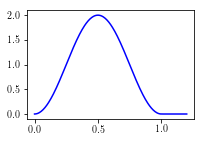

In [50]:
'''
Define the pump pulse parameters.  The pump pulse by default has a
sin**2 amplitude profile.

Parameters:
    lengthStirap - length of the pump pulse
    wStirap - pi / lengthStirap
    lengthSim - length of the simulation (as the photon can continue to decay
                out of the cavity after the pump pulse is over, we typically
                use lengthSim > lengthStirap).
    OmegaStirap - the peak Rabi frequency of the pump pulse.  Note that, again,
                  this does not include the angualr dependence of the
                  transition so the Rabi frequency on a given transition is
                        A * OmegaStirap
                where,
                    A: Angular dependence of the considered transition.
                e.g. A=np.sqrt(5/24) for F=1,mF=+/-1 <--> F=1,mF=1 in zero
                magnetic field.
'''
lengthStirap= 1
lengthSim = 1.2
OmegaStirap = 2 * 2 * np.pi

wStirap = np.pi / lengthStirap
t,tStep = np.linspace(0, lengthSim, 251, retstep=True)

Omega = lambda t, A=OmegaStirap, w=wStirap: np.piecewise(t, [t<lengthStirap], [A*np.sin(w*t)**2,0])

args_stirap = dict([('wStirap',wStirap), ('lengthStirap',lengthStirap), ('lengthSim',lengthSim)])

f, a1 = plt.subplots(figsize=(3, 2))
a1.plot(t, [Omega(x)/(2*np.pi) for x in t], 'b')
f.patch.set_facecolor('white')

In [51]:
'''
Create couplings for the Hamiltonian
'''

'''
Create a laser coupling.

Parameters:
    Omega - The peak rabi frequency of the pump pulse.
    g - The ground atomic atomic level.
    x - The excited atomic level.
    omegaL - The detuning of the pump laser.
    deltaM - The angular momentum change from g --> x.  This is ignored but included
             for consistancy with the cavityCoupling function.
    args_list - A dictionary of arguments for the qutip simulation.
    pulseShape - The shape of the pump pulse.
    
Returns:
    (List of cython-ready Hamiltonian terms,
     args_list with relevant parameters added)
'''
def laserCoupling(Omega,g,x,omegaL,deltaM,args_list,pulseShape='np.sin(w*t)**2'):
     omegaL_lab = 'omegaL_{0}{1}'.format(g,x)
     args_list[omegaL_lab] = omegaL
     return (
         [
         [ -(Omega/2)*(
                ( kb([g,0,0],[x,0,0]) + kb([g,0,1],[x,0,1]) + kb([g,1,0],[x,1,0]) + kb([g,1,1],[x,1,1]) ) +
                ( kb([x,0,0],[g,0,0]) + kb([x,0,1],[g,0,1]) + kb([x,1,0],[g,1,0]) + kb([x,1,1],[g,1,1]) )
        ),'{0} * np.cos({1}*t)'.format(pulseShape,omegaL_lab)],
        [ i*(Omega/2)*(
                ( kb([x,0,0],[g,0,0]) + kb([x,0,1],[g,0,1]) + kb([x,1,0],[g,1,0]) + kb([x,1,1],[g,1,1]) ) -
                ( kb([g,0,0],[x,0,0]) - kb([g,0,1],[x,0,1]) - kb([g,1,0],[x,1,0]) - kb([g,1,1],[x,1,1]) )
        ),'{0} * np.sin({1}*t)'.format(pulseShape,omegaL_lab)]
         ],
     args_list
     )
    
'''
Create a cavity coupling.

Parameters:
    g0 - The atom-cavity coupling rate.
    g - The ground atomic atomic level.
    x - The excited atomic level.
    omegaC - The detuning of the cavity resonance.
    deltaM - The angular momentum change from g --> x.
    args_list - A dictionary of arguments for the qutip simulation.
    
Returns:
    (List of cython-ready Hamiltonian terms,
     args_list with relevant parameters added)
'''
def cavityCoupling(g0,g,x,omegaC,deltaM,args_list):    
    omegaC_X = omegaC + deltaP/2
    omegaC_Y = omegaC - deltaP/2
    omegaC_X_lab = 'omegaC_X_{0}{1}'.format(g,x)
    omegaC_Y_lab = 'omegaC_Y_{0}{1}'.format(g,x)
    
    args_list[omegaC_X_lab] = omegaC_X
    args_list[omegaC_Y_lab] = omegaC_Y

    if deltaM==1:
        H_coupling = (
            [
                [ -g0*alpha*(
                    kb([g,1,0],[x,0,0])+ kb([g,1,1],[x,0,1]) + kb([x,0,0],[g,1,0]) + kb([x,0,1],[g,1,1])
                ),'np.cos({0}*t - phi1)'.format(omegaC_X_lab)],
                
                [ -i*g0*alpha*(
                    kb([g,1,0],[x,0,0])+ kb([g,1,1],[x,0,1]) - kb([x,0,0],[g,1,0]) - kb([x,0,1],[g,1,1])
                ),'np.sin({0}*t - phi1)'.format(omegaC_X_lab)],
                
                [ g0*beta*(
                    kb([g,0,1],[x,0,0]) + kb([g,1,1],[x,1,0]) + kb([x,0,0],[g,0,1]) + kb([x,1,0],[g,1,1])
                ),'np.cos({0}*t - phi2)'.format(omegaC_Y_lab)], 
        
                [ i*g0*beta*(
                    kb([g,0,1],[x,0,0]) + kb([g,1,1],[x,1,0]) - kb([x,0,0],[g,0,1]) - kb([x,1,0],[g,1,1])
                ),'np.sin({0}*t - phi2)'.format(omegaC_Y_lab)]
            ],
            args_list
        )
    elif deltaM==-1:
        H_coupling = (
            [
                [ -g0*alpha*(
                    kb([g,0,1],[x,0,0])+ kb([g,1,1],[x,1,0]) + kb([x,0,0],[g,0,1]) + kb([x,1,0],[g,1,1])
                ),'np.cos({0}*t + phi1)'.format(omegaC_Y_lab)],
                
                [ -i*g0*alpha*(
                    kb([g,0,1],[x,0,0])+ kb([g,1,1],[x,1,0]) - kb([x,0,0],[g,0,1]) - kb([x,1,0],[g,1,1])
                ),'np.sin({0}*t + phi1)'.format(omegaC_Y_lab)],
                
                [ -g0*beta*(
                    kb([g,1,0],[x,0,0]) + kb([g,1,1],[x,0,1]) + kb([x,0,0],[g,1,0]) + kb([x,0,1],[g,1,1])
                ),'np.cos({0}*t + phi2)'.format(omegaC_X_lab)], 
        
                [ -i*g0*beta*(
                    kb([g,1,0],[x,0,0]) + kb([g,1,1],[x,0,1]) - kb([x,0,0],[g,1,0]) - kb([x,0,1],[g,1,1])
                ),'np.sin({0}*t + phi2)'.format(omegaC_X_lab)]
            ],
            args_list
        )
    else:
        raise Exception("deltaM must be +/-1")
    
    return H_coupling

'''
Get the laser and cavity couplings for between
all configured levels with angular momentum changes
of +/-1.

Parameters:
    delta - The detuning of the coupling field.
'''
def getCouplings_SigmaPlus(delta):
    return [ 
    ('gM', 'x0', delta, 1)
    ]

def getCouplings_SigmaMinus(delta):
    return [ 
    ('gP', 'x0', delta, -1)
    ]

'''
Define the couplings used here.
'''
# Setting the cavity to coupling the transition with deltaM=-1 from g->x will produce sigma_- photons
cavityCouplings = getCouplings_SigmaMinus(deltaC)
laserCouplings  = getCouplings_SigmaPlus(deltaL)
#laserCouplings = []

# Setting the cavity to coupling the transition with deltaM=+1 from g->x will produce sigma_+ photons
# cavityCouplings = getCouplings_SigmaPlus(deltaC)
# laserCouplings  = getCouplings_SigmaMinus(deltaL)

'''
Convert a list of couplings as returned by getCouplings...() to a list
of time dependent Hamiltonian terms as required by qutip.mesolve(...).

Needs: couplings:  the list of couplings as returned by getCouplings...()
       rabiFreq:   the intensity of the couplings (with angular dependence factored out)
       pulseShape: the shape of the pulse (in the string format for mesolve compilation
                   into Cython.
                   If None the coupling is presumed constant and a cavityCoupling(...)
                   is set, otherwise laserCoupling(...) is used.

Returns: hams: the list of Hamiltonian terms
         args_hams: the dictionary of args needed by qutip.mesolve
'''
def couplingsToHamiltonians(couplings, rabiFreq, pulseShape=None):
    hams, args_hams = [], dict()
    for x in couplings:
        # Check if this is a coupling between configured states.
        if  x[0] in atomStates and x[1] in atomStates:
            if pulseShape != None:
                ham, args_ham = laserCoupling(rabiFreq, x[0], x[1], x[2], x[3], args_hams, pulseShape) 
            else:
                ham, args_ham = cavityCoupling(rabiFreq, x[0], x[1], x[2], x[3], args_hams) 
            hams.append(ham)
    return list(chain(*hams)), args_hams

'''
Create Hamiltonian terms for configured couplings.
'''
hams_cavity, args_hams_cavity = couplingsToHamiltonians(cavityCouplings, g)
hams_laser, args_hams_laser = couplingsToHamiltonians(laserCouplings, OmegaStirap,
                                                 'np.piecewise(t, [t<lengthStirap], [np.sin(wStirap*t)**2,0])')


'''
The full list of Hamiltonian terms and arguments.
'''
H_Stirap = list(chain(*[hams_cavity, hams_laser]))
args_hams_Stirap = {**args_hams_cavity,**args_hams_laser,
                    **args_stirap,**args_system}

In [52]:
'''
When repeatedly simulating a system where only the time-dependent variables,
or initial state change, it is possible to reuse the Hamiltonian data stored
in QuTiP and there by avoid spending time needlessly preparing the Hamiltonian
and collapse terms for simulation. To turn on the the reuse features, we must
pass a qutip.Options object with the rhs_reuse flag turned on, or we can
pre-compile the Hamiltonian and pass it explicitly to the solver. 
'''

# A list of Hamiltonians to pre-compile in the form:
#    (Cythonied Hamiltonian, arguement dictionary, compiled file name)
H_list = [
    (H_Stirap, args_hams_Stirap, 'H_Stirap')
]

H_rhs_compiled=[]

for H, args, label in H_list:
    t_start = time.time()
    rhs_generate(H, c_op_list, args=args, name=label, cleanup=False)
    H_rhs_compiled.append(H)
    print('Hamiltonian \'{0}\': states pre-computed in in {1} seconds'.format(label, time.time()-t_start))

Hamiltonian 'H_Stirap': states pre-computed in in 0.014842033386230469 seconds


In [53]:
'''
Perform simulation
'''
t,tStep = np.linspace(0, lengthSim, 501, retstep=True)

psi0 = ket(*['gM',0,0]) # Initial state of the system

opts = Options(rhs_reuse=False, rhs_filename='H_Stirap')

t_start = time.time()
    
output = mesolve(H_Stirap, psi0, t, c_op_list, [], args=args_hams_Stirap, options=opts, progress_bar=None)

print('Simulation with {0} timesteps completed in {1} seconds'.format(
t.size,np.round(time.time()-t_start,3) ))

Simulation with 501 timesteps completed in 0.246 seconds


Photon emission (Circ): 0.67
Photon emission (Lin): 0.67
Photon emission (Cav): 0.67
Photon emission (Mir): 0.67
Total spontaneous emission: 0.0
Photon / Total spontaneous emission: inf
Final pops: |1,-1>,|1,1>: 0.324 0.671


/anaconda3/envs/qutip-env-tdb/lib/python3.6/site-packages/ipykernel_launcher.py:103: RuntimeWarning: divide by zero encountered in double_scalars


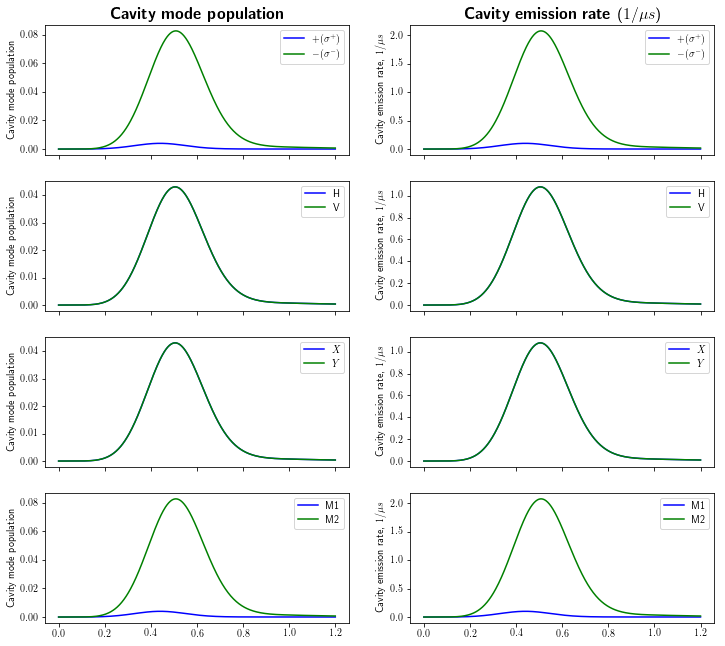

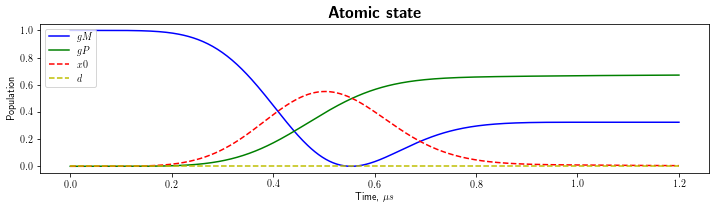

In [54]:
'''
Handle simulation results.  Here we produce plots showing the
photon emission in three polarisation bases:
    - circular {|+>,|->},
    - cavity {|X>,|Y>},
    - linear {|H>,|V>},
and the evolution of the atomic state.
'''
output_states = output.states

'''
Photon number operators for calculating the intra-cavity population in
different polarisation bases.
'''
anP_t,anM_t = anRot_series(t, alpha=alpha, phi1=phi1, phi2=phi2)

alpha_LC = np.clip(np.abs(R_LC[0, 0]),0,1)
phi1_LC, phi2_LC = np.angle(R_LC[0, 0]), np.angle(R_LC[1, 0])

alpha_MC = np.clip(np.abs(R_MC[0, 0]),0,1)
phi1_MC, phi2_MC = np.angle(R_MC[0, 0]), np.angle(R_MC[1, 0])

anH_t,anV_t = anRot_series(t, alpha=alpha_LC, phi1=phi1_LC, phi2=phi2_LC)
anM1_t,anM2_t = anRot_series(t, alpha=alpha_MC, phi1=phi1_MC, phi2=phi2_MC)

exp_anP, exp_anM, exp_anH, exp_anV, exp_anM1, exp_anM2 =\
    np.abs(np.array(
        [expect(list(an_list), state) for an_list,state in zip(zip(anP_t,anM_t, anH_t,anV_t, anM1_t,anM2_t),
                                                               output_states)]
        )).T

exp_anX, exp_anY, exp_spontDecay =\
    np.abs( expect([anX, anY, sigma_spontDecayOp], output_states) )

'''
Photon number operators for calculating cavity emission different polarisation
bases.
'''
R_AM = R_LM*R_AL
alpha_AM = np.clip(np.abs(R_AM[0, 0]),0,1)
phi1_AM, phi2_AM = np.angle(R_AM[0, 0]), np.angle(R_AM[1, 0])

alpha_LM = np.clip(np.abs(R_LM[0, 0]),0,1)
phi1_LM, phi2_LM = np.angle(R_LM[0, 0]), np.angle(R_LM[1, 0])

alpha_CM = np.clip(np.abs(R_CM[0, 0]),0,1)
phi1_CM, phi2_CM = np.angle(R_CM[0, 0]), np.angle(R_CM[1, 0])
 
# emP, emM = em_op(alpha_AM, phi1_AM, phi2_AM)
# emH, emV = em_op(alpha_LM, phi1_LM, phi2_LM)
# emX, emY = em_op(alpha_CM, phi1_CM, phi2_CM)
# emM1, emM2 = em_op(1, 0, 0)
# 
# exp_emP, exp_emM, exp_emH, exp_emV, exp_emX, exp_emY, exp_emM1, exp_emM2 =\
#     np.abs( expect([emP, emM, emH, emV, emX, emY, emM1, emM2], output_states) )

emP_t,emM_t = emRot_series(t, alpha_AM, phi1_AM, phi2_AM)
emH_t,emV_t = emRot_series(t, alpha_LM, phi1_LM, phi2_LM)
emX_t,emY_t = emRot_series(t, alpha_CM, phi1_CM, phi2_CM)
emM1_t, emM2_t = emRot_series(t, 1, 0, 0)

exp_emP, exp_emM, exp_emH, exp_emV, exp_emX, exp_emY, exp_emM1, exp_emM2 =\
    np.abs(np.array(
        [expect(list(an_list), state) for an_list,state in zip(zip(emP_t,emM_t,
                                                                   emH_t,emV_t,
                                                                   emX_t,emY_t,
                                                                   emM1_t, emM2_t),
                                                               output_states)]
        )).T

# Total photonic emission of each mode.
n_P = np.trapz((exp_emP), dx=tStep)
n_M = np.trapz((exp_emM), dx=tStep)

n_H = np.trapz((exp_emH), dx=tStep)
n_V = np.trapz((exp_emV), dx=tStep)

n_X = np.trapz((exp_emX), dx=tStep)
n_Y = np.trapz((exp_emY), dx=tStep)

n_M1 = np.trapz(2*kappa1*(exp_anM1), dx=tStep)
n_M2 = np.trapz(2*kappa2*(exp_anM2), dx=tStep)

n_ph_circ = n_P + n_M
n_ph_lin = n_H + n_V
n_ph_cav = n_X + n_Y
n_ph_mir = n_M1 + n_M2

# Total spontaneous emission.
n_spont = np.trapz(exp_spontDecay, dx=tStep)

# Atomic populations
exp_agM,exp_agP,exp_ax0,exp_ad =\
    np.abs( expect([agM,agP,ax0,ad], output_states) )

'''
Summaries
'''
plt.rcParams['text.usetex'] = True

print('Photon emission (Circ):', np.round(n_ph_circ,3))
print('Photon emission (Lin):', np.round(n_ph_lin,3))
print('Photon emission (Cav):', np.round(n_ph_cav,3))
print('Photon emission (Mir):', np.round(n_ph_mir,3))

print('Total spontaneous emission:', np.round(n_spont,3))
print('Photon / Total spontaneous emission:', np.round(n_ph_circ/n_spont,3))

print('Final pops: |1,-1>,|1,1>:', np.round(exp_agM[-1],3),np.round(exp_agP[-1],3))

# Plot the results
f1, ((a1a, a1b), 
     (a2a, a2b),
     (a3a, a3b),
     (a4a, a4b)) = plt.subplots(4, 2, sharex=True, figsize=(12, 11))

a1a.set_title('\\textbf{Cavity mode population}', fontsize=16)
a1b.set_title('\\textbf{Cavity emission rate} ($1/\mu s$)', fontsize=16, fontweight='bold')

###
axA,axB = a1a,a1b

axA.plot(t, exp_anP, 'b', label='$+ (\sigma^{+})$')
axA.plot(t, exp_anM, 'g', label='$- (\sigma^{-})$')
axA.set_ylabel('Cavity mode population')
axA.legend(loc=1)

axB.plot(t, exp_emP, 'b', label='$+ (\sigma^{+})$')
axB.plot(t, exp_emM, 'g', label='$- (\sigma^{-})$')
axB.set_ylabel('Cavity emission rate, $1/\mu s$')
axB.legend(loc=1)

###
axA,axB = a2a,a2b

axA.plot(t, exp_anH, 'b', label='H')
axA.plot(t, exp_anV, 'g', label='V')
axA.set_ylabel('Cavity mode population')
axA.legend(loc=1)

axB.plot(t, exp_emH, 'b', label='H')
axB.plot(t, exp_emV, 'g', label='V')
axB.set_ylabel('Cavity emission rate, $1/\mu s$')
axB.legend(loc=1)

###
axA,axB = a3a,a3b

axA.plot(t, exp_anX, 'b', label='$X$')
axA.plot(t, exp_anY, 'g', label='$Y$')
axA.set_ylabel('Cavity mode population')
axA.legend(loc=1)

axB.plot(t, exp_emX, 'b', label='$X$')
axB.plot(t, exp_emY, 'g', label='$Y$')
axB.set_ylabel('Cavity emission rate, $1/\mu s$')
axB.legend(loc=1)

###
axA,axB = a4a,a4b

axA.plot(t, exp_anM1, 'b', label='M1')
axA.plot(t, exp_anM2, 'g', label='M2')
axA.set_ylabel('Cavity mode population')
axA.legend(loc=1)

# axB.plot(t, 2*kappa1 * exp_anM1, 'b', label='M1')
# axB.plot(t, 2*kappa2 * exp_anM2, 'g', label='M2')
# axB.set_ylabel('Cavity emission rate, $1/\mu s$')
# axB.legend(loc=1)
axB.plot(t, exp_emM1, 'b', label='M1')
axB.plot(t, exp_emM2, 'g', label='M2')
axB.set_ylabel('Cavity emission rate, $1/\mu s$')
axB.legend(loc=1)

f2, (a) = plt.subplots(1, 1, sharex=True, figsize=(12, 11/4))

a.set_title('\\textbf{Atomic state}', fontsize=16)

a.plot(t, exp_agM, 'b', label='$gM$')
a.plot(t, exp_agP, 'g', label='$gP$')
a.plot(t, exp_ax0, '--r', label='$x0$')
a.plot(t, exp_ad, '--y', label='$d$')

a.set_xlabel('Time, $\mu s$')
a.set_ylabel('Population')
a.legend(loc=2)

In [63]:
alpha_AM

1.0